## Imports

In [1]:
import random
import json
from datasets import Dataset
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig, TrainerCallback, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
from transformers import DataCollatorForLanguageModeling
from transformers import TrainingArguments, Trainer
from peft import PeftModel
import matplotlib.pyplot as plt
import os

c:\Users\Alonso\Documents\## UPM\TFM\git\TFM\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else "No GPU")

CUDA available: True
Device count: 1
Current device: 0
Device name: NVIDIA GeForce RTX 4090


In [ ]:
data = pd.read_csv("../data/diagnoses_df/ground_truth_df.csv")
data

,Descripcion_diagnosticos,Descripcion_diagnosticos_limpio,Codigos_diagnosticos,Diagnosticos_estandar
0,F30.2 - MANÍA CON SÍNTOMAS PSICÓTICOS.,f30.2 mania con sintomas psicoticos.,['F30.9'],"['Episodio maníaco, no especificado']"
1,\r\nDescompensación rasgos patológicos de pers...,descompensacion rasgos patologicos de personal...,"['F60.3', 'F79.0']",['Trastorno de inestabilidad emocional de la p...
2,Intento de suicidio,intento de suicidio,"['F31.3', 'F32.9', 'T14.91']","['Trastorno bipolar, episodio actual depresivo..."
3,ID: trastorno adaptativo,id trastorno adaptativo,['F43.2'],['Trastorno de adaptación']
4,JC: Episodio depresivo con intento autolitico ...,jc episodio depresivo con intento autolitico f...,"['F32.9', 'T14.91']","['Episodio depresivo sin especificación', 'Sui..."
...,...,...,...,...
79043,"-Negativa a la ingesta, agitación y alteracion...",negativa a la ingesta agitacion y alteraciones...,"['F4.0', 'F41.1', 'F60.4', 'COGNITIV', 'F13.0']","['Trastorno de ansiedad, disociativo, relacion..."
79044,"Eje I: \r\n-Psicosis no especificada, leve des...",eje i psicosis no especificada leve descompens...,"['F32.9', 'F33.9', 'F60.3', 'Z63', 'F12.0', 'F...","['Episodio depresivo sin especificación', 'Tra..."
79045,T ansiedad con insomnio plurifactorial.,t ansiedad con insomnio plurifactorial.,"['F4.0', 'F51.0']","['Trastorno de ansiedad, disociativo, relacion..."
79046,"- T. de ansiedad con insomnio comórbido, en re...",t. de ansiedad con insomnio comorbido en remis...,"['F4.0', 'F51.0']","['Trastorno de ansiedad, disociativo, relacion..."


## Crear dataset para el fine tuning

In [4]:
# 1. Lista original de diagnósticos
diagnosticos = data['Descripcion_diagnosticos'].dropna().astype(str).tolist()


# Parámetros
porcentaje_json = 0.05  # 5%
tam_json = 3            # diagnósticos por bloque JSON

# 2. Mezclar y separar
random.shuffle(diagnosticos)
n_total = len(diagnosticos)
n_json = int(n_total * porcentaje_json)
n_rest = n_total - (n_json * tam_json)

# 3. Crear bloques JSON
json_blocks = []
for i in range(n_json):
    block = diagnosticos[i * tam_json: (i + 1) * tam_json]
    if len(block) == tam_json:
        json_blocks.append(json.dumps({"diagnosticos": block}, ensure_ascii=False))

# 4. Frases individuales
frases_sueltas = diagnosticos[n_json * tam_json:]

# 5. Combinar todo
final_texts = frases_sueltas + json_blocks
random.shuffle(final_texts)

# 6. Convertir a HuggingFace Dataset
hf_dataset = Dataset.from_dict({"text": final_texts})
splits = hf_dataset.train_test_split(test_size=0.1, seed=42)
train_ds = splits["train"]
val_ds   = splits["test"]

In [5]:
final_texts

['T. por dependencia a BZD.',
 ' Reacción de adptación',
 'Distimia, episodio depresivo reactivo a situación vital',
 ' Trastorno esquizoafectivo',
 '- T. depresivo, en remisión parcial.\r\n- Trastorno de la conducta alimentaria.\r\n- Historial traumático.\r\n- A valorar patología eje II cluster B.',
 'Episodio psicótico (mayo 2021)',
 ' Ludopatía',
 'No psicopatologia',
 'Rasgos de personalidad cluster B',
 ' Personalidad narcisista',
 'Enuresis nocturna primaria\r\nAlteración del sueño, con despertares y pesadillas.',
 '{"diagnosticos": ["posible s. amotivacional secundario a consumo de cannabis.", "Dependencia a cannabis", "Sintomas de ansiedad reactivos a situación laboral."]}',
 'Conflicto relación.',
 'Riesgo autolesivo/autolítico',
 'Dependencia a benzodiacepinas',
 'Reaccion de adaptacion a situacion familiar disfuncional',
 'Trastorno depresivo episodio grave, actualmente en recuperación y asintomático',
 'TP Orgánico. Demencia.',
 'Ideación autolítica, resuelta.',
 'Trastorno

## Cargar modelo

In [ ]:
model_name = "meta-llama/Llama-3.2-3B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.float16
)

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


## Aplicar LORA

In [7]:
lora_config = LoraConfig(
    r=64,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)

## Preparar dataset tokenizado

In [8]:
def tokenize(example):
    return tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=256,
    )

tokenized_train = train_ds.map(tokenize, batched=True, remove_columns=["text"])
tokenized_val   = val_ds.map(tokenize,   batched=True, remove_columns=["text"])

Map: 100%|██████████| 7115/7115 [00:00<00:00, 10763.99 examples/s]


## Data collator para CLM (no enmascarado)

In [ ]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # causal language modeling
)

## Configurar entrenamiento

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",

    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    num_train_epochs=10,
    learning_rate=2e-4,
    fp16=False,

    logging_steps=100,
    eval_strategy="steps",
    eval_steps=100,
    per_device_eval_batch_size=8,

    save_strategy="epoch",
    report_to="none"
)

## Entrenar

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss
100,3.032000,2.792541
200,2.456000,2.574683
300,2.298200,2.369545
400,2.178500,2.272448
500,2.060400,2.210550
600,2.044600,2.168655
700,1.990200,2.133789
800,1.955200,2.113074
900,1.951100,2.097038
1000,1.930500,2.066065


💾 Loss log updated at ./loss_logs\loss_log.csv
💾 Loss log updated at ./loss_logs\loss_log.csv
💾 Loss log updated at ./loss_logs\loss_log.csv
💾 Loss log updated at ./loss_logs\loss_log.csv
💾 Loss log updated at ./loss_logs\loss_log.csv
💾 Loss log updated at ./loss_logs\loss_log.csv
💾 Loss log updated at ./loss_logs\loss_log.csv
💾 Loss log updated at ./loss_logs\loss_log.csv
💾 Loss log updated at ./loss_logs\loss_log.csv
💾 Loss log updated at ./loss_logs\loss_log.csv


c:\Users\Alonso\Documents\## UPM\TFM\git\TFM\venv\Lib\site-packages\peft\utils\other.py:1110: UserWarning: Unable to fetch remote file due to the following error (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: c6afadd1-d15a-4555-bd24-82ade4a95cfa)') - silently ignoring the lookup for the file config.json in meta-llama/Llama-3.2-3B-Instruct.
  warnings.warn(
c:\Users\Alonso\Documents\## UPM\TFM\git\TFM\venv\Lib\site-packages\peft\utils\save_and_load.py:236: UserWarning: Could not find a config file in meta-llama/Llama-3.2-3B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(


💾 Loss log updated at ./loss_logs\loss_log.csv


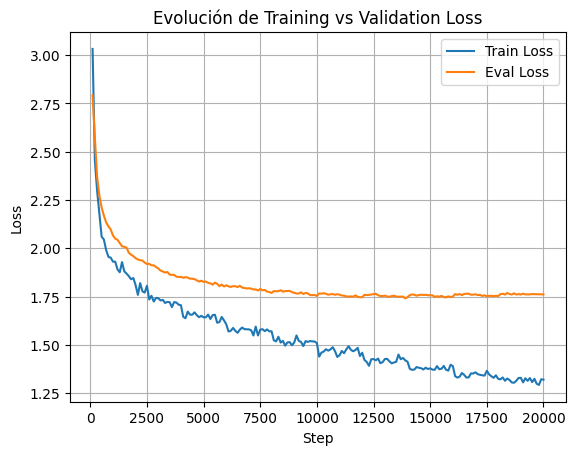

In [ ]:
class PersistentLossLoggerCallback(TrainerCallback):
    def __init__(self, output_dir="./loss_logs"):
        self.output_dir = output_dir
        os.makedirs(self.output_dir, exist_ok=True)
        self.csv_path = os.path.join(self.output_dir, "loss_log.csv")
        self.records = []
        # Si ya existe, cargamos los pasos anteriores
        if os.path.exists(self.csv_path):
            existing = pd.read_csv(self.csv_path)
            self.existing_steps = set(existing["step"].tolist())
            self.records = existing.to_dict("records")
        else:
            self.existing_steps = set()

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None:
            return
        step = state.global_step
        train_loss = logs.get("loss", None)
        eval_loss  = logs.get("eval_loss", None)

        if step in self.existing_steps:
            return  # Evita duplicados tras reanudación

        if train_loss is not None or eval_loss is not None:
            self.records.append({
                "step": step,
                "train_loss": train_loss,
                "eval_loss": eval_loss
            })
            self.existing_steps.add(step)

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        step = state.global_step
        # Buscar la última entrada con ese step
        for record in reversed(self.records):
            if record["step"] == step:
                record["eval_loss"] = metrics.get("eval_loss", None)
                break
        else:
            # No se encontró step anterior, lo añadimos nuevo
            self.records.append({
                "step": step,
                "train_loss": None,
                "eval_loss": metrics.get("eval_loss", None)
            })
            self.existing_steps.add(step)
            
    def _save_log(self):
        df = pd.DataFrame(self.records)
        df.to_csv(self.csv_path, index=False)
        print(f"💾 Loss log updated at {self.csv_path}")

    def on_epoch_end(self, args, state, control, **kwargs):
        self._save_log()

    def on_train_end(self, args, state, control, **kwargs):
        self._save_log()


loss_logger = PersistentLossLoggerCallback()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator=data_collator,
    callbacks=[loss_logger]
)

trainer.train()
# trainer.train(resume_from_checkpoint=True)

df = pd.DataFrame(loss_logger.records)

# Es posible que en algunas filas sólo exista train_loss o sólo eval_loss;
# Se rellena hacia adelante para alinear ambas curvas en el plot.
df["train_loss"] = df["train_loss"].ffill()
df["eval_loss"]  = df["eval_loss"].ffill()

# Graficamos ambas
plt.plot(df["step"], df["train_loss"], label="Train Loss")
plt.plot(df["step"], df["eval_loss"],  label="Eval Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Evolución de Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

## Exportar LORA

In [12]:
model.save_pretrained("../finetuned_models/loras/finetuned-llama-diagnosticos") 
tokenizer.save_pretrained("../finetuned_models/loras/finetuned-llama-diagnosticos")

c:\Users\Alonso\Documents\## UPM\TFM\git\TFM\venv\Lib\site-packages\peft\utils\other.py:1110: UserWarning: Unable to fetch remote file due to the following error (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: b988e800-e579-4736-ab10-42b07db58567)') - silently ignoring the lookup for the file config.json in meta-llama/Llama-3.2-3B-Instruct.
  warnings.warn(
c:\Users\Alonso\Documents\## UPM\TFM\git\TFM\venv\Lib\site-packages\peft\utils\save_and_load.py:236: UserWarning: Could not find a config file in meta-llama/Llama-3.2-3B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(


('../finetuned_models/loras/finetuned-llama-diagnosticos\\tokenizer_config.json',
 '../finetuned_models/loras/finetuned-llama-diagnosticos\\special_tokens_map.json',
 '../finetuned_models/loras/finetuned-llama-diagnosticos\\chat_template.jinja',
 '../finetuned_models/loras/finetuned-llama-diagnosticos\\tokenizer.json')

## Mergear LORA cono modelo original para tenerlo unido y poder servirlo con vLLM

In [ ]:
BASE_MODEL = "meta-llama/Llama-3.2-3B-Instruct"
ADAPTER_PATH = "../finetuned_models/loras/finetuned-llama-diagnosticos"
OUTPUT_DIR   = "../finetuned_models/merged_models/finetuned-llama-diagnosticos"

# 1. Cargar el modelo base en fp16
base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    torch_dtype=torch.float16,
    device_map="auto",
)

# 2. Cargar el PeftModel (el base_model + el adapter)
peft_model = PeftModel.from_pretrained(
    base_model,
    ADAPTER_PATH,
    device_map="auto",
)

# 3. Merge: incrustra los pesos LoRA en el modelo base y descarga el wrapper
merged = peft_model.merge_and_unload()

# 4. Guardar el modelo “plano” completo
merged.save_pretrained(OUTPUT_DIR)

tokenizer.save_pretrained(OUTPUT_DIR)

# Copia la configuración de generación. Esto carga generation_config.json del modelo base y lo guarda en OUTPUT_DIR
gen_conf = GenerationConfig.from_pretrained(BASE_MODEL)
gen_conf.save_pretrained(OUTPUT_DIR)

print(f"✅ Todo listo en {OUTPUT_DIR}: modelo + tokenizer + generation_config.")

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


✅ Todo listo en ../finetuned_models/merged_models/finetuned-llama-diagnosticos: modelo + tokenizer + generation_config.
